Previous Reference Research: Short-Term Load Forecasting using Bi-directional Sequential Models and Feature Engineering for Small Datasets 
https://arxiv.org/pdf/2011.14137v1.pdf

Ref blog 1: Load Forecasting using Machine Learning
https://valohai.com/blog/smart-grids-use-machine-learning-to-forecast-load/

Ref blog 2: How to Select a Model For Your Time Series Prediction Task  
https://neptune.ai/blog/select-model-for-time-series-prediction-task

Ref blog 3: How to Develop LSTM Models for Time Series Forecasting
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/



Model 1 Feature Set:

1. Electricity Load for Day-1(MW), Hour-1
2. Timestamp
3. Day of the week
4. Month of the year
5. Electricty Price
6. Humidity


In [984]:
import pandas as pd
import numpy as np
import plotly.express as px
import IPython
import IPython.display
import sklearn
from scipy import interpolate
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing   

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


# 1. Data Loading

In [985]:
data = pd.read_csv('/Users/alvis/Downloads/ercot-dataset.csv',index_col='Date')

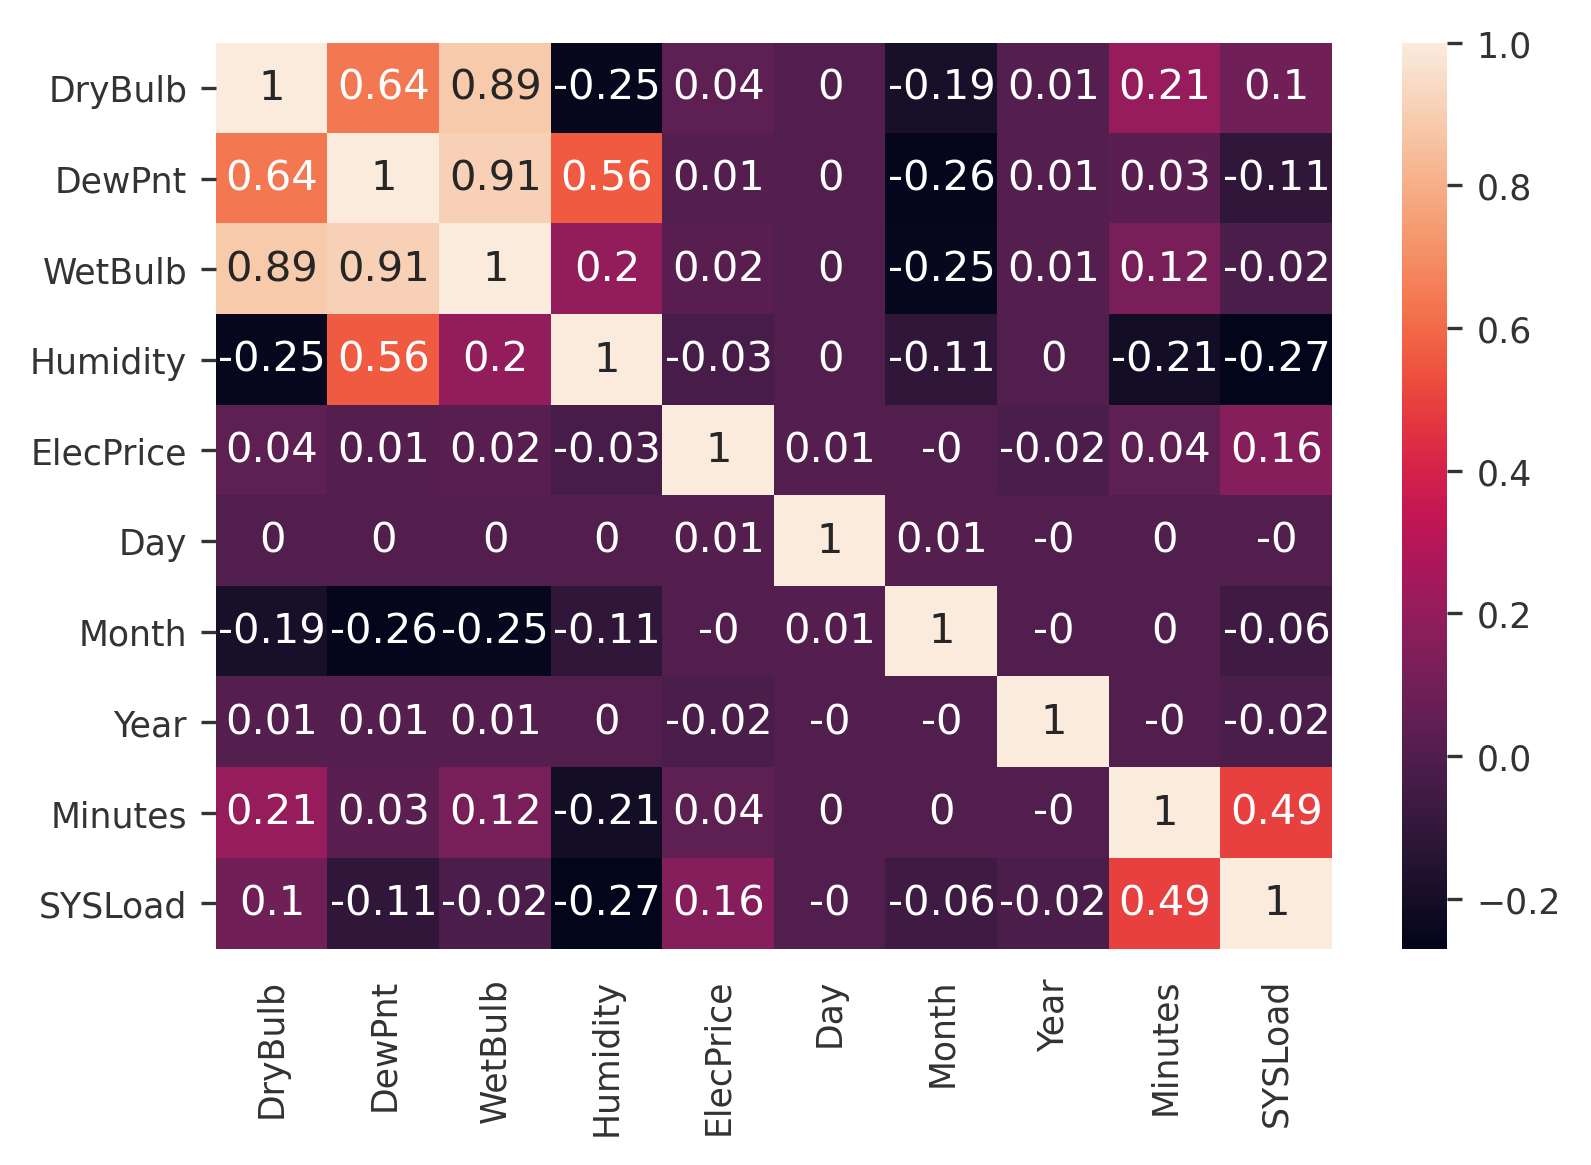

In [986]:
correlation_matrix = data.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Displaying the correlation matrix to check level of relationship b/w various variables and SYSLoad. The variables holding the highest correlation are to be used as the basic features. 
Looking at the above matrix, we see that the variables holding the highest correlation with SYSLoad are in the following order:
a) Humidity
b) Electricity Price 

In [987]:
# Dropping other variables that do not hold any considerable correlation with SYSLoad for tractability
data = data.drop(['DryBulb','DewPnt','WetBulb','Minutes','Day','Month','Year'],axis=1)
data.index = pd.DatetimeIndex(data=data.index)
data = data.resample('30min').mean()

# 2. Data Analysis

## 2a. Statistics Summary

Below are the general statistics of the dataset
count    87648.000000
mean      8894.000513
std       1409.045641
min       5498.360000
25%       7879.667500
50%       8992.585000
75%       9832.855000
max      14274.150000
Name: SYSLoad, dtype: float64


Text(0.5, 1.0, 'Distribution of SYSLoad Data ')

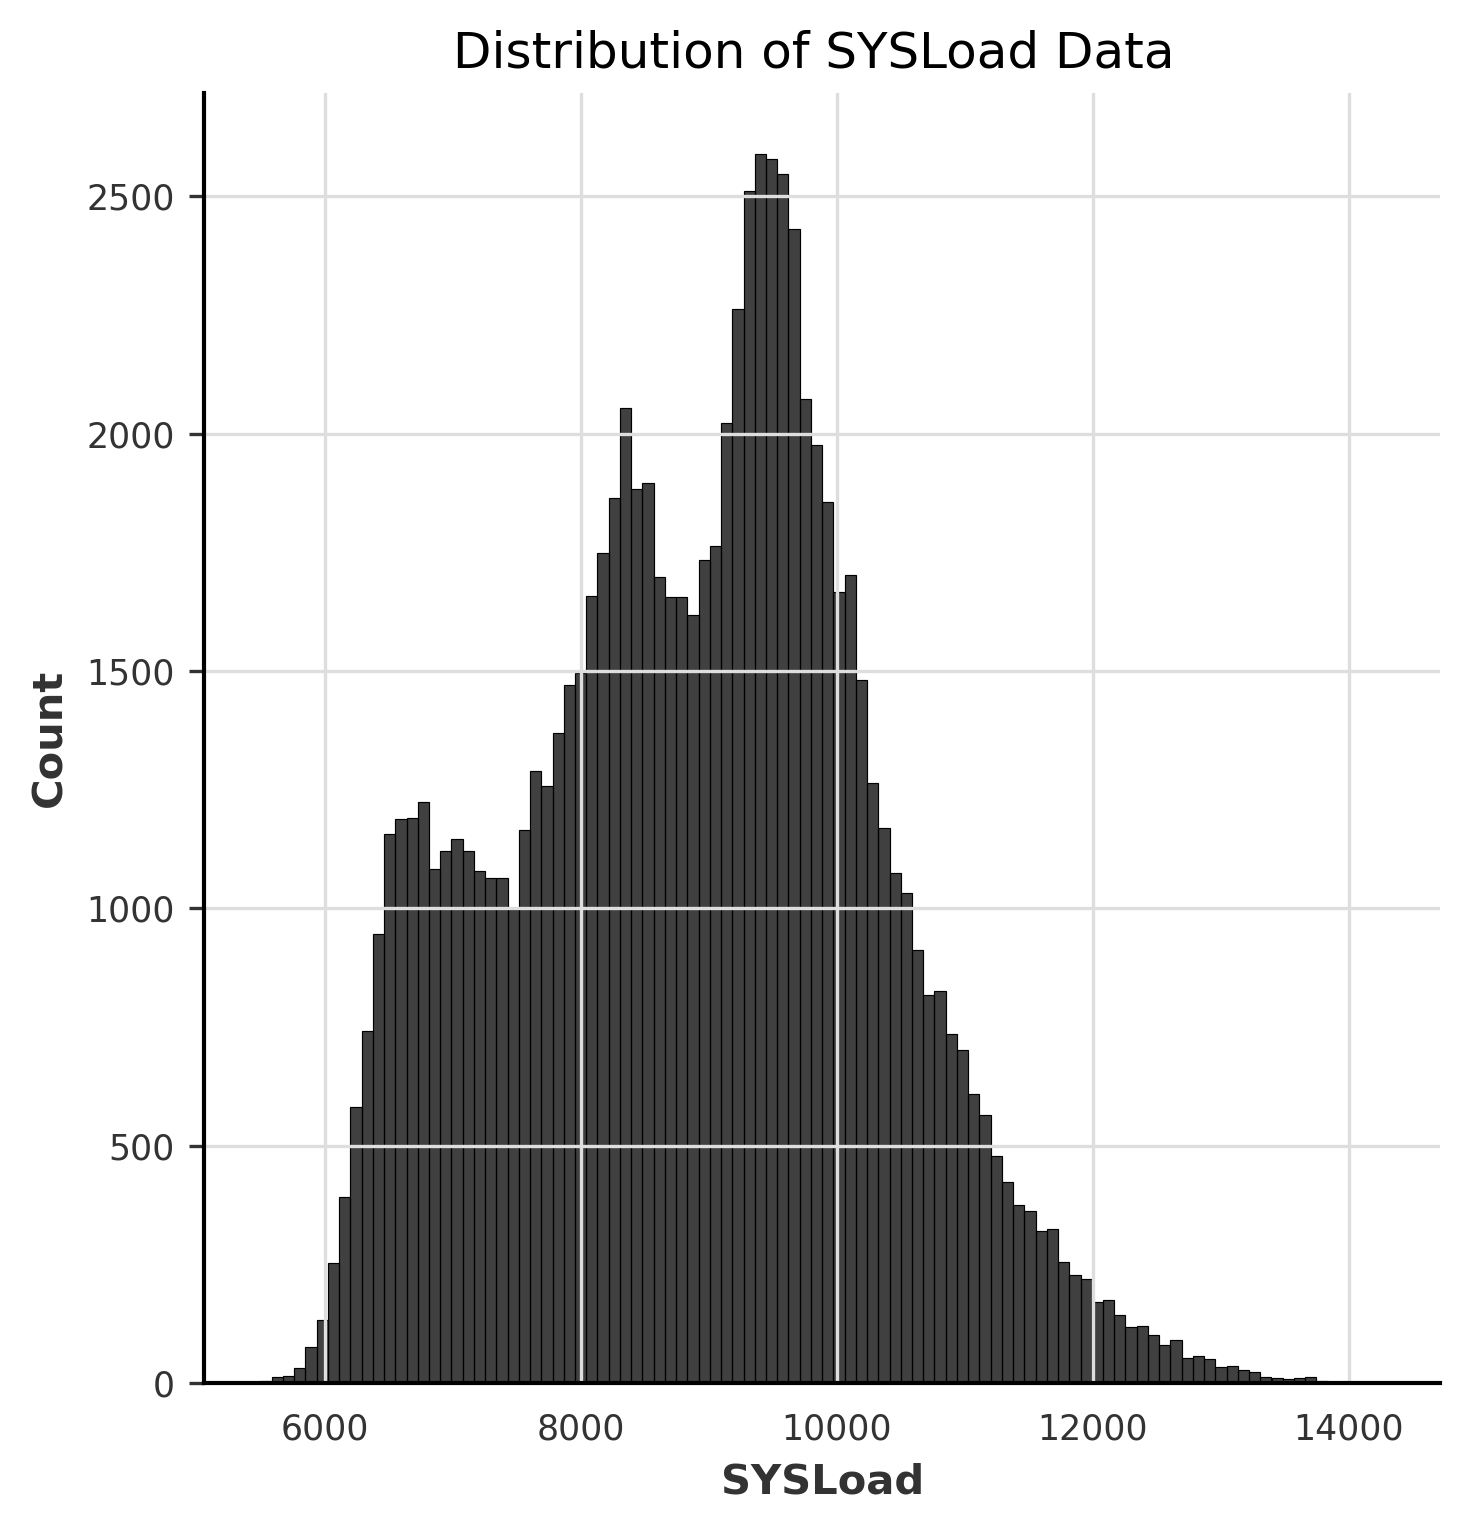

In [988]:
print ("Below are the general statistics of the dataset")
print(data['SYSLoad'].describe())     # Description of load data

sns.displot(data, x="SYSLoad")
plt.title("Distribution of SYSLoad Data ")

From the above analysis, we observe that 75% of the datapoints are lying below the value of 9832 MWs. So, in order to detect possible outliers in the remaining 25% of datapoints, we use z-score analysis. Z-score analysis involve caluclation of z-scores of every datapoint and compare it with a threshold (that we set). All the datapoints that lie above the threshold would be removed. 

### Outlier detection and treatment

In [989]:
mean = np.mean(data['SYSLoad'])
std = np.std(data['SYSLoad'])

threshold = 4
newLoad = []

for datapoint in data['SYSLoad']:
    z = (datapoint-mean)/std
    if z <= threshold:
        newLoad.append(datapoint)
    else:
        newLoad.append(mean)

In [990]:
data['new SYSLoad'] = newLoad  

Z-score implies the deviation of the datapoint from the mean, thus higher the z-score, higher will be the deviation of the datapoint from the mean. Points that are few in number and are lying too far from the mean can be treated  as outliers and can be removed to make the data clean. 
Here, the z-score threshold has been taken as 4. For this value of z-score, the datapoint value goes beyond 14485 MW. Any abrupt values beyond this point will be removed from the data as an outlier. The threshold can be changed depending on the data.

## 2b.

### Check for missing values

In [991]:
data.info()   

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87648 entries, 2006-01-01 00:30:00 to 2011-01-01 00:00:00
Freq: 30T
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Humidity     87648 non-null  float64
 1   ElecPrice    87648 non-null  float64
 2   SYSLoad      87648 non-null  float64
 3   new SYSLoad  87648 non-null  float64
dtypes: float64(4)
memory usage: 3.3 MB


Comment: 
The above summary shows that: 
1. The dataset ranges from date 01-01-2006 to 01-01-2011
2. The resolution of the dataset is 30 minutes.
2. There are no missing values in any of the columns in the dataset

### Interpolate the missing values if any

In [992]:
data.interpolate(method="polynomial", order=2)

,Humidity,ElecPrice,SYSLoad,new SYSLoad
Date,,,,
2006-01-01 00:30:00,87.5,19.67,8013.27833,8013.27833
2006-01-01 01:00:00,88.0,18.56,7726.89167,7726.89167
2006-01-01 01:30:00,88.0,19.09,7372.85833,7372.85833
2006-01-01 02:00:00,88.0,17.40,7071.83333,7071.83333
2006-01-01 02:30:00,88.0,17.00,6865.44000,6865.44000
...,...,...,...,...
2010-12-31 22:00:00,81.0,23.86,8449.54000,8449.54000
2010-12-31 22:30:00,81.5,26.49,8508.16000,8508.16000
2010-12-31 23:00:00,82.0,25.18,8413.14000,8413.14000


Although there are no missing datapoints in our dataset, we are implementing an interpolation operation on the dataset, in case a differnt dataset is used in future.

## 2c. ACF 

Text(0, 0.5, 'Autocorrelation Coefficient')

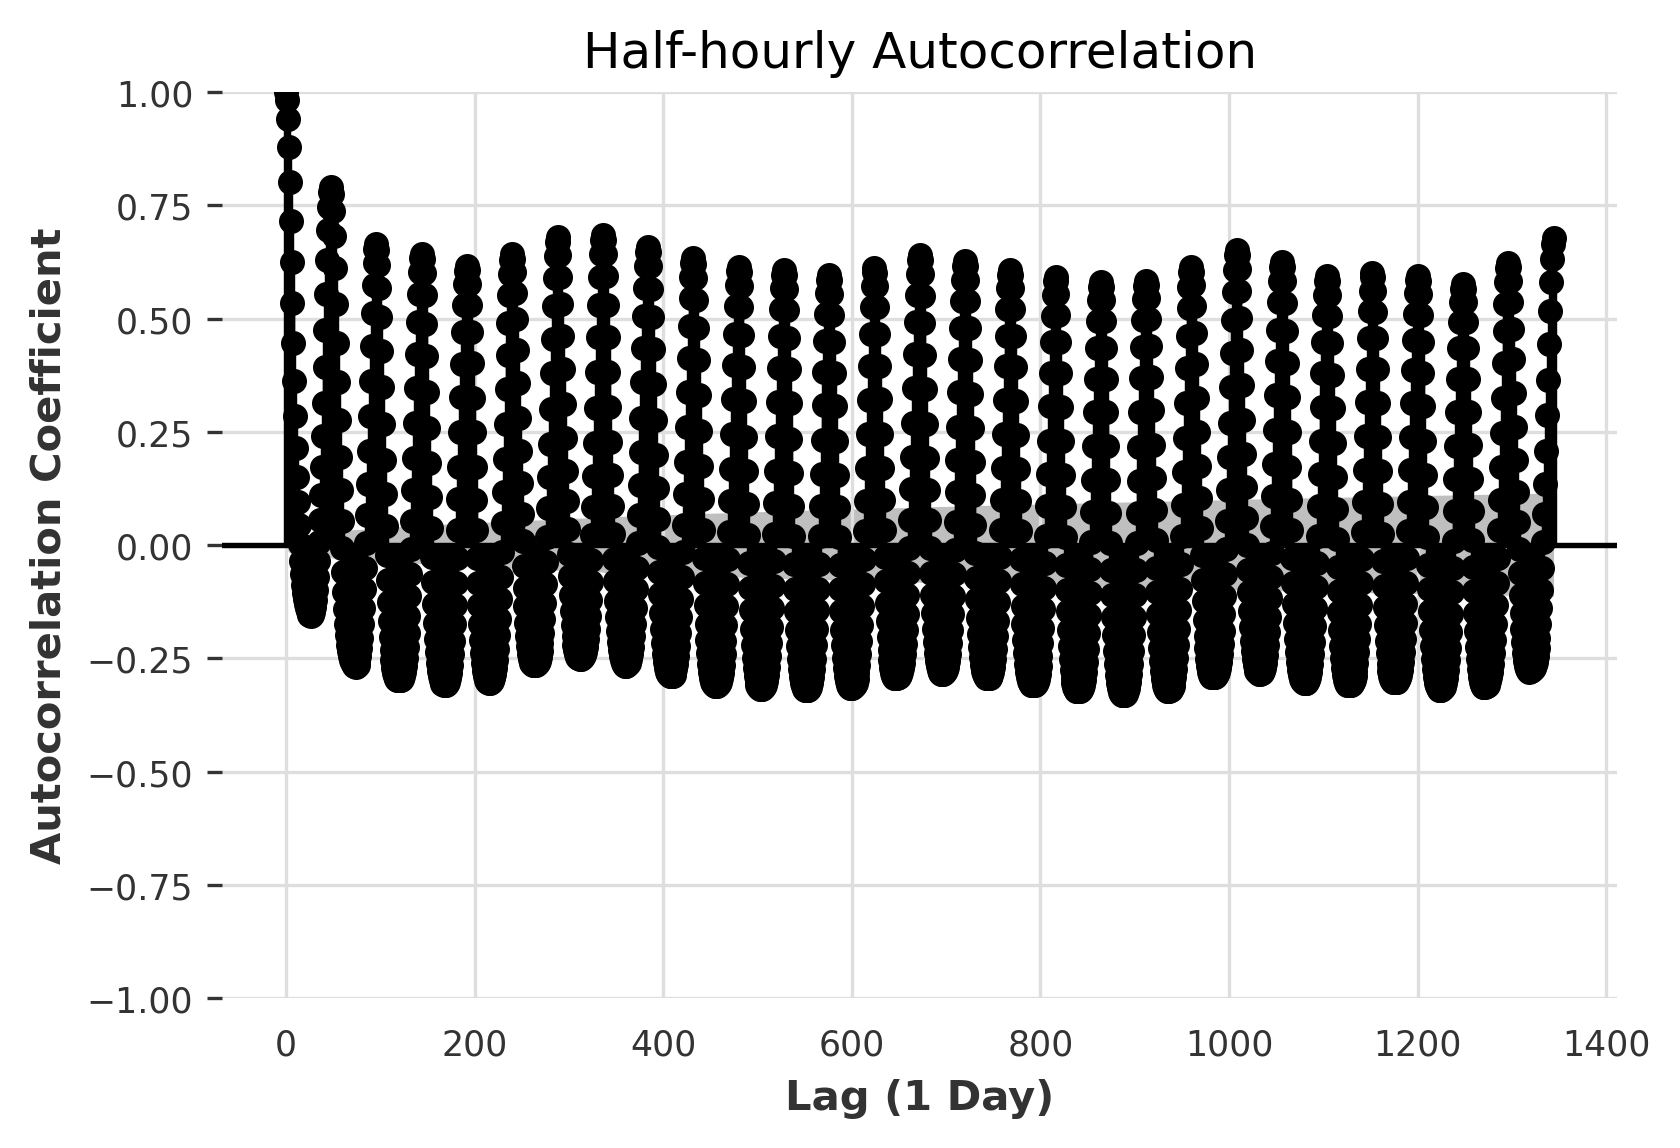

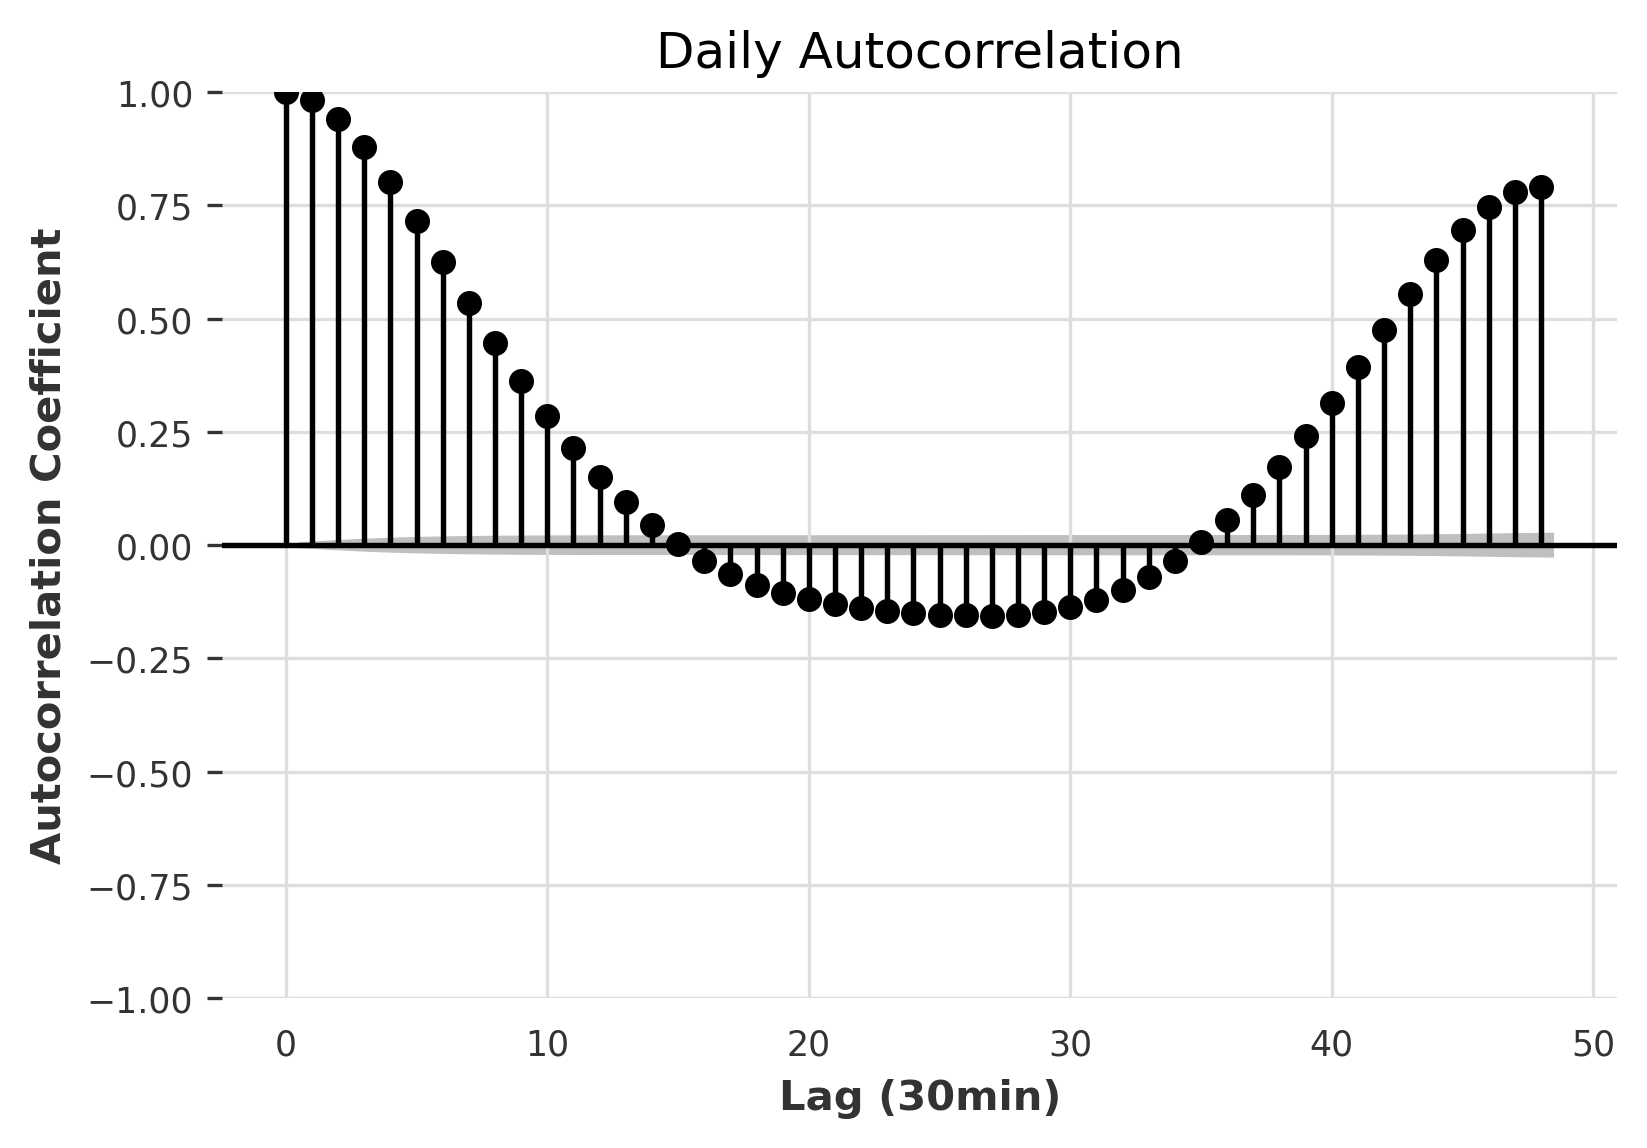

In [993]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data.SYSLoad, lags=1344) #1344 half-hourly observtions in a month
plt.title("Half-hourly Autocorrelation")
plt.xlabel("Lag (1 Day)")
plt.ylabel("Autocorrelation Coefficient")

plot_acf(data.SYSLoad, lags=48) #48 half-hourly observtions in a day
plt.title("Daily Autocorrelation")
plt.xlabel("Lag (30min)")
plt.ylabel("Autocorrelation Coefficient")


Since it is a time-series data, we are checking autocorrelation of SYSLoad to derive features from the SYSLoad data with itself. These correlations show the effect of past values on the present value of the time-series data. The values show the momentum that past values carry in the present.

## 2d. Visualisation

The relevant variables are visualised to see the trend and relativity w.r.t. each other

Text(0, 0.5, 'Load (MW)')

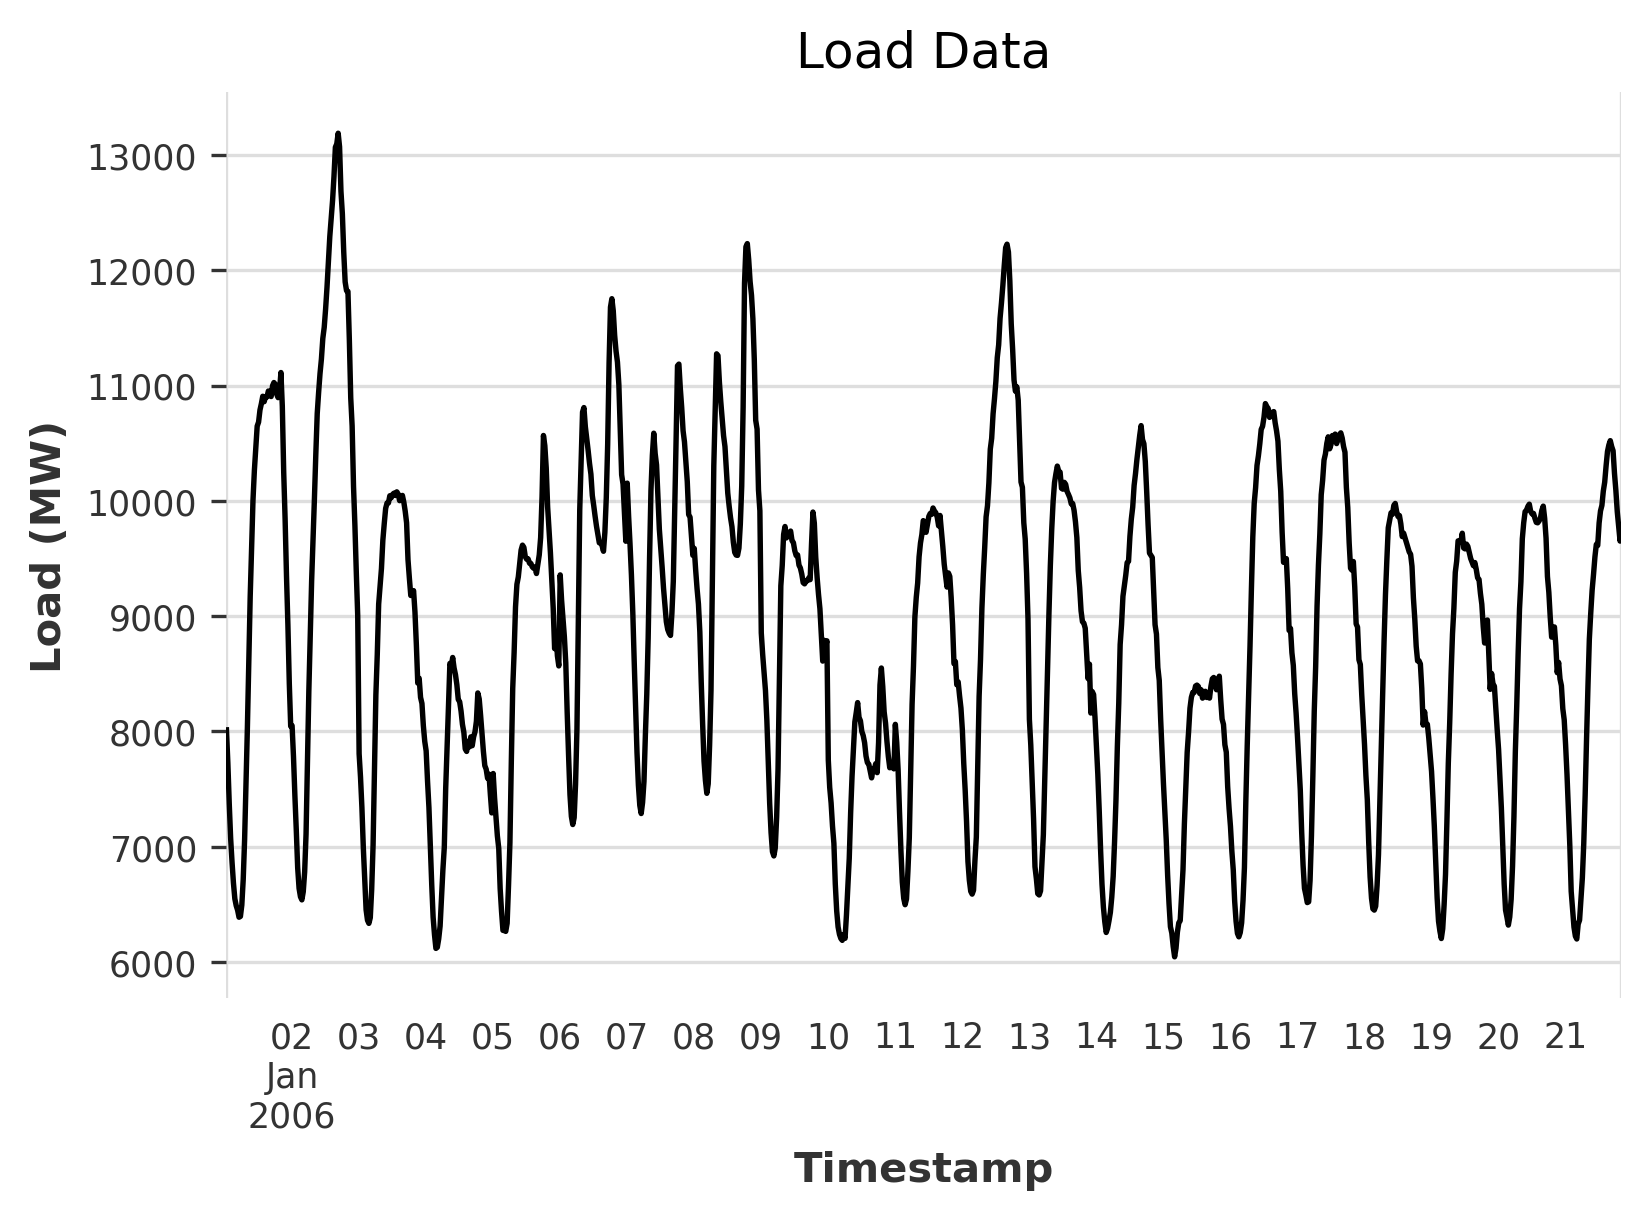

In [994]:
data['SYSLoad'].head(1000).plot()
plt.title("Load Data")
plt.xlabel("Timestamp")
plt.ylabel("Load (MW)")

When we visualise the entire above load data, we make the following observations:

1. The highest consumption occurs b/w Jun to Aug, with one peak at around 9:30AM and other at 6:30PM
2. The lowest average consumptions are b/w march to may and b/w sep to nov


## Data Decomposition

In [995]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
seasonality = seasonal_decompose(data.SYSLoad.head(1000), model = 'additive',period=5)
seasonality = seasonality.plot()
seasonality = plotly.tools.mpl_to_plotly(seasonality)
seasonality.update_layout(width = 1100, height = 500, title = 'Seasonal Decomposition of Load Data')

A timeseriesusually consists of a trend, seasonality and a residual noise.

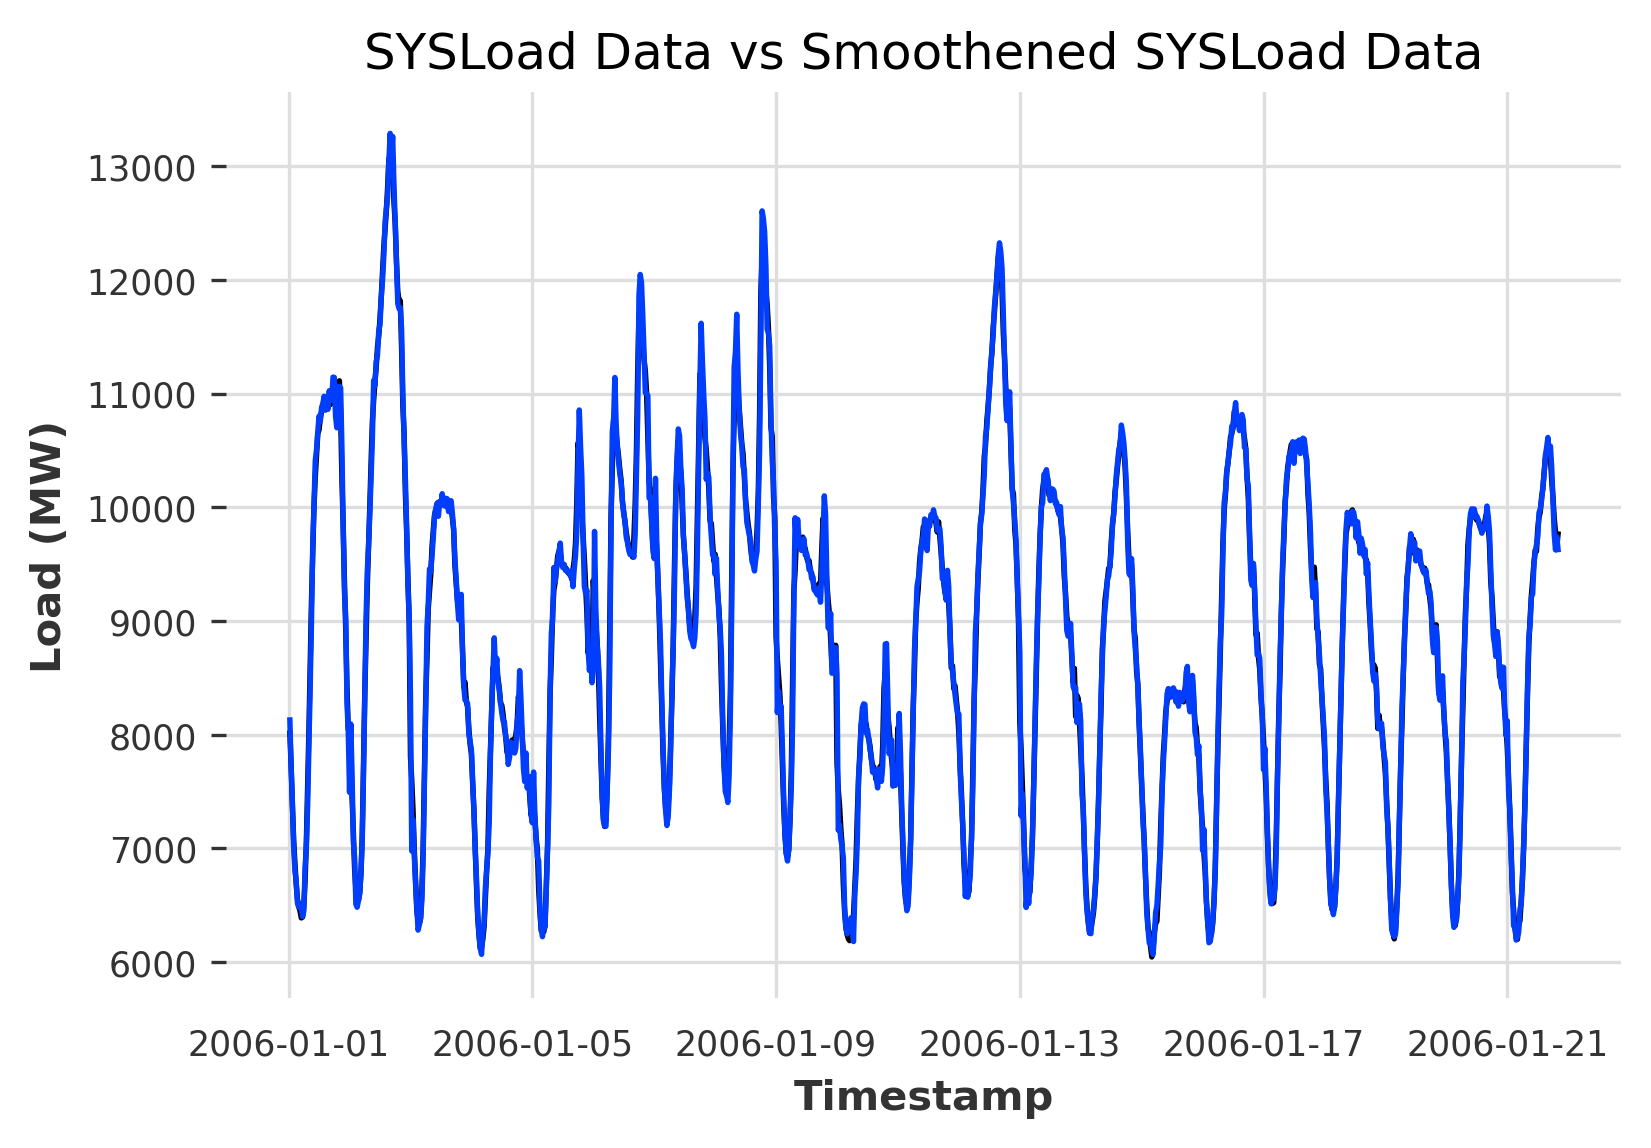

In [996]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
data['SYSLoad Smooth'] = ExponentialSmoothing(data['new SYSLoad'], seasonal_periods=336, trend='add', seasonal='add').fit().fittedvalues#.shift(-1)

plt.plot(data['SYSLoad'].head(1000))
plt.plot(data['SYSLoad Smooth'].head(1000))
plt.title("SYSLoad Data vs Smoothened SYSLoad Data")
plt.xlabel("Timestamp")
plt.ylabel("Load (MW)")
plt.show()

## https://www.kaggle.com/code/prakharprasad/smoothing-holt-winters-forecast

Removing the cyclic component essentially, makes the data sensitive to long term fluctuations and not to the short term fluctuations.

Moving Averages and Single Exponential Smoothing does a poor job of forecasting when there is trend and seasonality in the data. Double and Triple exponential smoothing is best suited for this kind of timeseries data.Holt winters has all the three variations - Single, Double and Triple exponential smoothing

Double Exponential smoothing uses a smoothing factor that addresses trend. Triple Exponential smoothing uses a smoothing factor that addresses seasonality.

## Try k-means clusterig to extract features i.e. clubbing day-wise data such that similar data is grouped together and used as one feature.  

Hodrick Prescott filter was developed for aggregate macro data in order to study business cycles at a quarterly, annual or at most monthly frequency. The filter was not meant to be for hourly data and I cannot imagine that it will perform well for your kind of application.

In [997]:
import datetime as dt
from datetime import datetime
data['DOW'] = data.index.to_series().dt.dayofweek
data['MOY'] = data.index.to_series().dt.month

# Encoding Day-of-week and Month-of-year as categories: 
data['DOW_encoded']=data['DOW'].astype('category')
data['MOY_encoded']=data['MOY'].astype('category')

In [998]:
dataGroup = dict(tuple(data.groupby('DOW')))

## Normalise data before using them as features

In [999]:

data = data.drop(['new SYSLoad','SYSLoad','DOW','MOY'],axis=1)
Indx = data.index
newColumns = ['SYSLoad Smooth','Humidity', 'ElecPrice','DOW_encoded','MOY_encoded' ]
data = data[newColumns]


from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, index=Indx, columns=newColumns)

data

,SYSLoad Smooth,Humidity,ElecPrice,DOW_encoded,MOY_encoded
Date,,,,,
2006-01-01 00:30:00,0.313846,0.865591,0.027667,1.000000,0.0
2006-01-01 01:00:00,0.270860,0.870968,0.027559,1.000000,0.0
2006-01-01 01:30:00,0.238565,0.870968,0.027610,1.000000,0.0
2006-01-01 02:00:00,0.197999,0.870968,0.027446,1.000000,0.0
2006-01-01 02:30:00,0.176955,0.870968,0.027407,1.000000,0.0
...,...,...,...,...,...
2010-12-31 22:00:00,0.350932,0.795699,0.028075,0.666667,1.0
2010-12-31 22:30:00,0.360374,0.801075,0.028331,0.666667,1.0
2010-12-31 23:00:00,0.340679,0.806452,0.028204,0.666667,1.0


We have grouped the entire dataset based on the day of the week, so now we have 7 time-series instead of one. The grouping of data is part of feature extraction

Plot day-wise SYSLoad to see commmon pattern

Reference article for below DTW code: https://ealizadeh.com/blog/introduction-to-dynamic-time-warping/

In [1000]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


# def compute_euclidean_distance_matrix(x, y) -> np.array:
#     dist = np.zeros((len(y), len(x)))
#     for i in range(len(y)):
#         for j in range(len(x)):
#             dist[i,j] = (x[j]-y[i])**2
#     return dist

def compute_accumulated_cost_matrix(x, y) -> np.array:
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

In [1001]:
def DayWiseComparison(a,b):
    
    # Tranform the input to 1-D array
    x = dataGroup[a].SYSLoad.head(50).values.reshape(-1,1)
    y = dataGroup[b].SYSLoad.head(50).values.reshape(-1,1)
    
    # Define a figure with 2 subplots
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(4,2))      
    fig.patch.set_visible(False)
    ax.axis('off')
    
    # Setup Euclidean Distance Inputs and plot
    xx = [(i, x[i]) for i in np.arange(0, len(x))]
    yy = [(j, y[j]) for j in np.arange(0, len(y))]
    for i, j in zip(xx, yy[:-2]):
        ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)
    ax.plot(x, '-ro', label='x', linewidth=1, markersize=1, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(y, '-bo', label='y', linewidth=1, markersize=1, markerfacecolor='skyblue', markeredgecolor='skyblue')
    ax.set_title("Euclidean Distance b/w Daily Load Data Points", fontsize=3, fontweight="bold")

    
    # Setup DTW Distance Inputs and plot
    bx.axis('off')
    dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
    for [map_x, map_y] in warp_path:
        bx.plot([map_x, map_y], [x[map_x], y[map_y]], '--k', linewidth=1)

    bx.plot(x, '-ro', label='x', linewidth=1, markersize=1, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    bx.plot(y, '-bo', label='y', linewidth=1, markersize=1, markerfacecolor='skyblue', markeredgecolor='skyblue')
    bx.set_title("DTW Distance b/w Daily Load Data Points", fontsize=3, fontweight="bold")
    
    return (ax,bx)

Select the pair of days to check the distances between their daily sequence. 
e.g. to see the relation b/w Monday and Tuesday pattern, select 0 and 1.
 
- 0 - Monday
- 1 - Tuesday
- 2 - Wednesday
- 3 - Thursday
- 4 - Friday
- 5 - Saturday
- 6 - Sunday

(<AxesSubplot:title={'center':'Euclidean Distance b/w Daily Load Data Points'}>,
 <AxesSubplot:title={'center':'DTW Distance b/w Daily Load Data Points'}>)

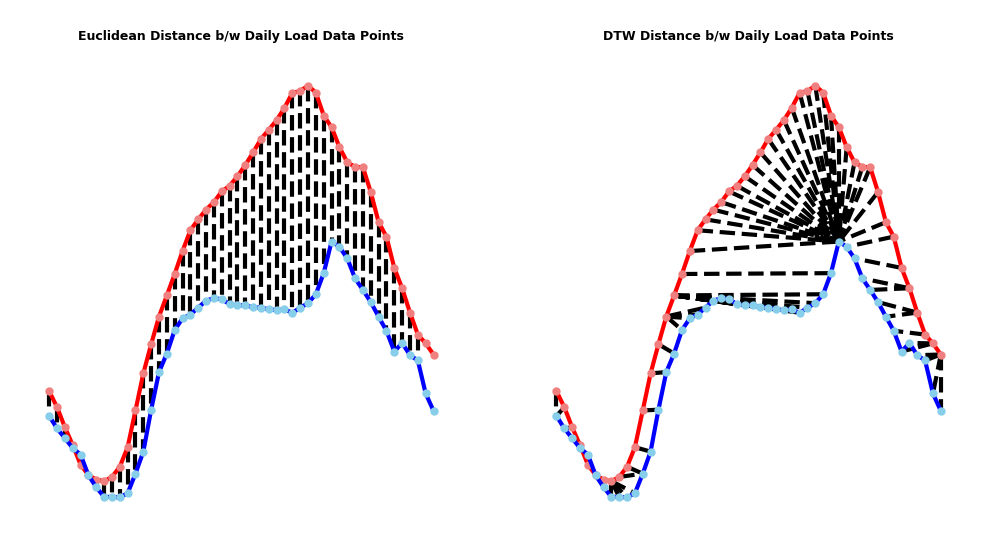

In [1002]:
# Please select the code in front of days in above cell to plot the distances:
DayWiseComparison(0,3)

Above graphs show how load pattern of each day is different and the crusts and troughs are not in sync for different days. When crusts and troughs do not align for datapoints for multiple days, the relationship building b/w load data for same timestamps on different days would be different and accuracy of prediction is compromised. Thus, Dynamic Time Warping (DTW) distance metric shows the pattern similarity b/w different days better than Euclidean distance metric.
- Since the load patterns for different days is not the same, we would want to encode each day as different via a numeric code and then feed the data to the model, so the model can dfferentiate b/w

In [1003]:
cost_matrix = compute_accumulated_cost_matrix(x, y)

## Feature Selection
1. 7-day lag load (previous week, same day) 
2. 1-day lag load
3. Name of the day
4. Grouping code of months (depending on the average high/low usage in winters/summers/in-between
5. Last 3 same day's average (e.g. last 3 mondays)
6. Humidity
7. Electricty Price

## Features and Target Setup

In [1004]:

features=[]
target=[]

trainStart = data.first_valid_index()
trainEnd = data.last_valid_index()

while trainStart<trainEnd:
    
    dayStart = trainStart
    dayEnd = dayStart +dt.timedelta(hours=23, minutes=30, seconds=00)
    dailyIndex = data.index[(data.index>=dayStart) & (data.index<dayEnd)]
    
    for date in dailyIndex:
        inputs=[]

        lag1 = startDate-dt.timedelta(days=1)
        lag7 = startDate-dt.timedelta(days=7)
        lag14 = startDate-dt.timedelta(days=14)
        lag21 = startDate-dt.timedelta(days=21)
        inputs.append(data['SYSLoad Smooth'].loc[lag7])
        inputs.append(data['SYSLoad Smooth'].loc[lag14])
        inputs.append(data['SYSLoad Smooth'].loc[lag21])     
        average = sum(inputs)/3
        
        features.append(average)
#        features.append(data.SYSLoad.loc[lag1])
        features.append(data.Humidity.loc[date])
        features.append(data.ElecPrice.loc[date])
        features.append(data.DOW_encoded.loc[date])
        features.append(data.MOY_encoded.loc[date])
        target.append(data['SYSLoad Smooth'].loc[date])
        
         
    trainStart = trainStart + dt.timedelta(hours=23, minutes=30, seconds=00)
    

In [1005]:

featuresArray = np.array(features).reshape(87648,5)  
targetArray = np.array(target).reshape(87648,1)

featuresArray

array([[0.22507065, 0.8655914 , 0.02766674, 1.        , 0.        ],
       [0.22507065, 0.87096774, 0.0275586 , 1.        , 0.        ],
       [0.22507065, 0.87096774, 0.02761023, 1.        , 0.        ],
       ...,
       [0.22507065, 0.80645161, 0.02820355, 0.66666667, 1.        ],
       [0.22507065, 0.82258065, 0.02830195, 0.66666667, 1.        ],
       [0.22507065, 0.83870968, 0.02814899, 0.83333333, 0.        ]])

n_timesteps or look_back in LSTM basically refers to the length of sequence (number of datapoints) we want to go in the past for LSTM to remember it.  
- [No.ofsamples, time_steps, features] is the shape of the input that LSTM model takes

In [1006]:
# trainFeatures = featuresArray[:60000]
# trainTarget = targetArray[:60000]
# testFeatures = featuresArray[60000:]
# testTarget = targetArray[60000:]

In [1007]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split


In [1008]:
xTrain, xTest, yTrain, yTest = train_test_split(featuresArray, targetArray, test_size=0.25, shuffle=False)


N : Samples - 87648
l : lag - 336 (7 days)
m : delay - 48
n : next steps - 48
d : dimension of data (i.e. number of columns in data) 6

k = N-(l+m+n) = 87648-(336+48+48) = 87216

input shape of dataset = (k,l,d) (87216,336,6)    e.g. t-l, t-l+1, t-l+2...   (t-336, t-335, t-334...
output shape of dataset = (k,n,d)    e.g. t+m, t+m+1, t+m+2... (t+48, t+49, t+50...


So if there are total N samples in data then the input and output shape of the entire data set would be (k,l,d) and (k,n,d) respectively.


In [1009]:
trainGenerator = TimeseriesGenerator(xTrain,yTrain, length=336, sampling_rate=1, batch_size=52)  #length of the sequence 
testGenerator = TimeseriesGenerator(xTest,yTest, length=336, sampling_rate=1, batch_size=52)  #length of the sequence 

In [1010]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Dropout
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Define model structure
model = Sequential()
# model.add(Bidirectional(LSTM(,input_shape=(48, 6))))
model.add(LSTM(128, input_shape=(336,5), return_sequences=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,  return_sequences=False)))
model.add(Dropout(0.3))
#model.add(Dense(25, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))


model.summary()


# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

model.fit_generator(trainGenerator, epochs=1, validation_data=testGenerator, shuffle=False, callbacks=earlyStopping)

model.evaluate_generator(testGenerator, verbose=0)

predictions = model.predict_generator(testGenerator)


print(round((accuracy_score(yTest, predictions) * 100), 2))

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 336, 128)          68608     
                                                                 
 bidirectional_39 (Bidirecti  (None, 336, 256)         263168    
 onal)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 336, 256)          0         
                                                                 
 bidirectional_40 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 1)               

ValueError: Found input variables with inconsistent numbers of samples: [21912, 21576]

In [ ]:
## We are doing only to inverse_transform the scaled input that we fed to the model. Because the scaling has been done on a dataframe with certain fixed columns, the scaling values are stored in the form of an array and in a certain sequence.
## So, in order to inverse the transform, we have to prepare a dataframe in the same structure as the original unscaled input, so that inverse_transform can take place successfully. 
df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(xTest[:,1:][336:])],axis=1)
df

In [ ]:
inv_trans = scaler.inverse_transform(df)
inv_trans

In [ ]:
newDf = df[predictions.shape[0]*-1:]

In [ ]:
newDf.count()

In [ ]:
newDf['new_SYSLoad'] = inv_trans[:,0]
newDf['new_SYSLoad'].plot()

In [ ]:
newDf

In [ ]:
data[['Humidity','ElecPrice','SYSLoad']].plot(subplots=True)